In [343]:
from utilities import *
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from tqdm import tqdm   # Permet de voir barre de progression 

In [344]:
X_train, y_train, X_test, y_test = load_data()

In [345]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("distribution: ", np.unique(y_train, return_counts = True))

X_train:  (1000, 64, 64)
y_train:  (1000, 1)
distribution:  (array([0., 1.]), array([500, 500]))


In [346]:
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("distribution: ", np.unique(y_test, return_counts = True))

X_test:  (200, 64, 64)
y_test:  (200, 1)
distribution:  (array([0., 1.]), array([100, 100]))


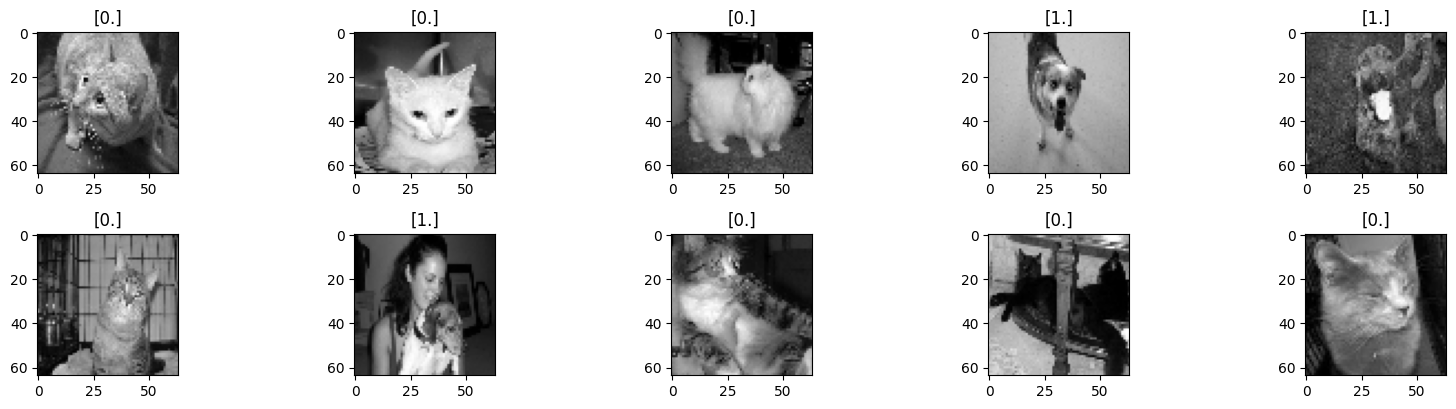

In [347]:
plt.figure(figsize = (16, 8))
for i in range(1, 11):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap= "gray")
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

### TODO
1- Normaliser le train_set et le test_set (0 - 255 --> 0 -1)<br>
2- Flatten() les variables du train_set et du test_set (64x64 --> 4096)<br>
3- Entrainer le model sur le train_set (tracer la courbe d'apprentissage, trouver les bons hyperparametres)<br>    si vous rencontrez un problème avec le log_loss, utiliser la fonction de sklearn à la place ! <br>
4- Evaluer le modele sur le test_set (tracer la courbe du Loss pour le test_set)

In [348]:
# Normaliser les images
X_train = X_train / X_train.max()
X_test = X_test / X_train.max()

In [349]:
# Applatir les image -> flatten() renvoie 1D alors qu'on veut 2D => reshape() marche 
X_train = X_train.reshape(X_train.shape[0], -1) # possibile de remplacer -1 par X_train.shape[1]*X_train.shape[2]
X_test = X_test.reshape(X_test.shape[0], -1)

In [350]:
X_train.shape

(1000, 4096)

In [351]:
# Initialisation des paramètres du modèle (poids et biais)
def initialisation(X):
    """
    Initialise les poids W et le biais b avec des valeurs aléatoires.
    
    Args:
        X (numpy.ndarray): Matrice des features (échantillons x caractéristiques).

    Returns:
        tuple: W (poids) de dimension (n_features, 1) et b (biais) scalaire.
    """
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return W, b

# Fonction d'activation sigmoïde et calcul de la sortie du modèle
def model(X, W, b):
    """
    Calcule la sortie du modèle en appliquant la fonction sigmoïde.

    Args:
        X (numpy.ndarray): Matrice des features.
        W (numpy.ndarray): Vecteur des poids.
        b (float): Biais.

    Returns:
        numpy.ndarray: Probabilités de la classe positive.
    """
    Z = X.dot(W) + b  # Calcul du score linéaire
    A = 1 / (1 + np.exp(-Z))  # Application de la fonction sigmoïde
    return A

# Fonction de coût (log-loss)
def log_loss(A, y):
    """
    Calcule la fonction de coût log-loss (entropie croisée).

    Args:
        A (numpy.ndarray): Probabilités prédites par le modèle.
        y (numpy.ndarray): Étiquettes réelles (0 ou 1).

    Returns:
        float: Valeur de la log-loss.
    """
    epsilon = 1.e-15  # Évite log(0) ou log(1) pour prévenir une erreur numérique => erreur: Overflow
    return (1 / len(y)) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

# Calcul des gradients pour la mise à jour des paramètres
def gradients(A, X, y):
    """
    Calcule les gradients du poids et du biais pour la descente de gradient.

    Args:
        A (numpy.ndarray): Probabilités prédites.
        X (numpy.ndarray): Matrice des features.
        y (numpy.ndarray): Étiquettes réelles.

    Returns:
        tuple: Gradients dW (pour W) et db (pour b).
    """
    dW = (1 / len(y)) * np.dot(X.T, (A - y))  # Gradient du poids
    db = (1 / len(y)) * np.sum(A - y)  # Gradient du biais
    return dW, db

# Mise à jour des paramètres avec la descente de gradient
def update(dW, db, W, b, learning_rate):
    """
    Met à jour les poids et le biais à l'aide de la descente de gradient.

    Args:
        dW (numpy.ndarray): Gradient des poids.
        db (float): Gradient du biais.
        W (numpy.ndarray): Poids actuels.
        b (float): Biais actuel.
        learning_rate (float): Taux d'apprentissage.

    Returns:
        tuple: Poids et biais mis à jour.
    """
    W -= learning_rate * dW  # Mise à jour des poids
    b -= learning_rate * db  # Mise à jour du biais
    return W, b

# Fonction de prédiction du modèle après entraînement
def predict(X, W, b):
    """
    Effectue une prédiction à partir des poids et du biais appris.

    Args:
        X (numpy.ndarray): Matrice des features.
        W (numpy.ndarray): Vecteur des poids.
        b (float): Biais.

    Returns:
        numpy.ndarray: Prédictions binaires (True = 1, False = 0).
    """
    A = model(X, W, b)  # Obtenir les probabilités
    return A >= 0.5  # Convertir en classe binaire

# Fonction d'entraînement du neurone artificiel
def artificial_neuron(X, y, learning_rate = 0.1, n_iter = 100):
    """
    Entraîne un neurone artificiel à l'aide de la descente de gradient.

    Args:
        X (numpy.ndarray): Matrice des features.
        y (numpy.ndarray): Étiquettes réelles.
        learning_rate (float, optional): Taux d'apprentissage. Par défaut 0.1.
        n_iter (int, optional): Nombre d'itérations d'entraînement. Par défaut 100.

    Returns:
        tuple: Poids W et biais b après entraînement.
    """
    # Initialisation des paramètres
    W, b = initialisation(X)

    # Suivi évolution log-loss et accuracy
    Loss = []
    accuracy = []

    # Boucle d'entraînement
    for i in tqdm(range(n_iter)):
        A = model(X, W, b)  

        if i % 10 == 0 :
            # Calcul du coût
            Loss.append(log_loss(A, y))  # Calcul des pertes
            
            # Calcul de l'accuracy
            y_pred = predict(X, W, b)
            accuracy.append(accuracy_score(y, y_pred))

            # Mise à jour pramettres
            dW, db = gradients(A, X, y)  # Calcul des gradients
            W, b = update(dW, db, W, b, learning_rate)


    # Affichage log-loss et accuracy
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(Loss)
    plt.subplot(1, 2, 2)
    plt.plot(accuracy)
  
    plt.show()

    return W, b


100%|██████████| 10000/10000 [00:47<00:00, 209.85it/s]


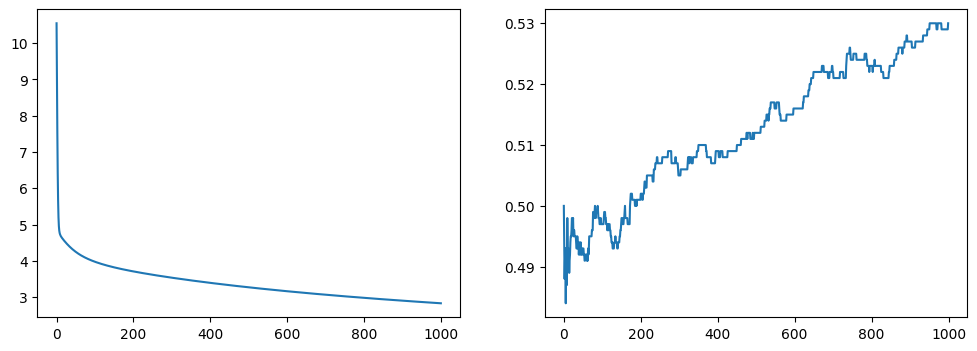

In [352]:
W, b = artificial_neuron(X_train, y_train, learning_rate= 0.01, n_iter = 10000)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def artificial_neuron(X_train, y_train, X_test, y_test, learning_rate=0.1, n_iter=100):
    """
    Entraîne un neurone artificiel en minimisant la log-loss via descente de gradient.

    Args:
        X_train (numpy.ndarray): Matrice des features d'entraînement.
        y_train (numpy.ndarray): Étiquettes d'entraînement.
        X_test (numpy.ndarray): Matrice des features de test.
        y_test (numpy.ndarray): Étiquettes de test.
        learning_rate (float, optional): Taux d'apprentissage. Par défaut 0.1.
        n_iter (int, optional): Nombre d'itérations d'entraînement. Par défaut 100.

    Returns:
        tuple: Poids W et biais b après entraînement.
    """
    # Initialisation des paramètres
    W, b = initialisation(X_train)

    # Suivi des métriques
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    # Boucle d'entraînement
    for i in tqdm(range(n_iter)):
        A = model(X_train, W, b)  

        # Mise à jour des paramètres (CORRECTION : à chaque itération, pas toutes les 10)
        dW, db = gradients(A, X_train, y_train)  
        W, b = update(dW, db, W, b, learning_rate)

        # Évaluation toutes les 10 itérations
        if i % 10 == 0:
            # Train
            train_loss.append(log_loss(A, y_train))
            y_pred_train = predict(X_train, W, b)
            train_accuracy.append(accuracy_score(y_train, y_pred_train))

            # Test
            A_test = model(X_test, W, b)  
            test_loss.append(log_loss(A_test, y_test))
            y_pred_test = predict(X_test, W, b)
            test_accuracy.append(accuracy_score(y_test, y_pred_test))

    # Affichage des courbes
    plt.figure(figsize=(12, 4))

    # Log-loss
    plt.subplot(1, 2, 1)
    plt.plot(range(0, n_iter, 10), train_loss, label="Train Loss", color="blue")
    plt.plot(range(0, n_iter, 10), test_loss, label="Test Loss", color="red")
    plt.xlabel("Itérations")
    plt.ylabel("Log Loss")
    plt.title("Évolution de la perte")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(0, n_iter, 10), train_accuracy, label="Train Accuracy", color="blue")
    plt.plot(range(0, n_iter, 10), test_accuracy, label="Test Accuracy", color="red")
    plt.xlabel("Itérations")
    plt.ylabel("Précision")
    plt.title("Évolution de l'accuracy")
    plt.legend()

    plt.show()

    return W, b


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\serig\AppData\Local\Temp\ipykernel_76048\3235979113.py:30: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))  # Application de la fonction sigmoïde
C:\Users\serig\AppData\Local\Temp\ipykernel_76048\3235979113.py:30: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))  # Application de la fonction sigmoïde
  0%|          | 18/10000 [00:00<00:56, 176.20it/s]C:\Users\serig\AppData\Local\Temp\ipykernel_76048\3235979113.py:30: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))  # Application de la fonction sigmoïde
C:\Users\serig\AppData\Local\Temp\ipykernel_76048\3235979113.py:30: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))  # Application de la fonction sigmoïde
  0%|          | 36/10000 [00:00<00:57, 173.58it/s]C:\Users\serig\AppData\Local\Temp\ipykernel_76048\3235979113.py:30: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))  # App

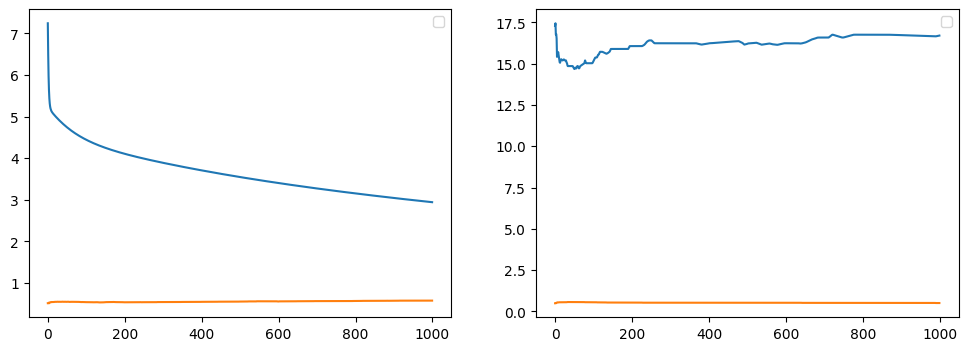

In [364]:
W, b = artificial_neuron(X_train, y_train, X_test, y_test,  learning_rate= 0.01, n_iter = 10000)